In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [ ]:
# File paths for flash drought, soil moisture, and potential evaporation data
flash_drought_path = 'path/result_HUC4_0110.csv'

# Load datasets
flash_drought_df = pd.read_csv(flash_drought_path)

# Filter and preprocess data for the specified date range
start_date = '2022-01-01'
end_date = '2022-12-31'

# Flash drought data
flash_drought_df['Date'] = pd.to_datetime(flash_drought_df['Date'])
flash_drought_df = flash_drought_df[(flash_drought_df['Date'] >= start_date) & (flash_drought_df['Date'] <= end_date)]

In [22]:
#calculte the mean daily precipitation
# Load datasets
flash_drought_pr = pd.read_csv(flash_drought_path,parse_dates=['Date'])
flash_drought_pr['Month']=flash_drought_pr['Date'].dt.month
flash_drought_pr['Day']=flash_drought_pr['Date'].dt.day

daily_mean_pr=flash_drought_pr.groupby(['Month','Day'])['precipitation'].mean().reset_index()
print(daily_mean_pr)

     Month  Day  precipitation
0        1    1       2.727548
1        1    2       2.722060
2        1    3       5.185766
3        1    4       3.028191
4        1    5       2.386107
..     ...  ...            ...
361     12   27       2.229489
362     12   28       2.792929
363     12   29       4.641371
364     12   30       2.436112
365     12   31       2.376547

[366 rows x 3 columns]


In [23]:
# Ensure month and day values are strings and properly formatted
daily_mean_pr['Month'] = daily_mean_pr['Month'].astype(int)
daily_mean_pr['Day'] = daily_mean_pr['Day'].astype(int)

# Construct the full date (assuming a known year, e.g., 2022)
daily_mean_pr['Full_Date'] = pd.to_datetime(
    '2022-' + daily_mean_pr['Month'].astype(str) + '-' + daily_mean_pr['Day'].astype(str), 
    errors='coerce'  # This will convert invalid dates to NaT instead of raising an error
)

# Drop rows with NaT values (invalid dates)
daily_mean_pr = daily_mean_pr.dropna(subset=['Full_Date'])

In [24]:
# List of methods
methods = ["Alencar et al.", "Noguera et al.", "Osman et al.", 
           "Ford and Labosier", "Pendergrass et al.", "Christian et al."]

# Initialize a list to store the results
event_list = []

# Loop through each method to find start and end dates of flash drought events
for method in methods:
    df = flash_drought_df[['Date', method]].copy()
    
    # Identify start (0 to 1) and end (1 to 0) of flash drought events
    df['Start'] = (df[method].diff() == 1)
    df['End'] = (df[method].diff() == -1)
    
    # Get start and end dates
    start_dates = df.loc[df['Start'], 'Date'].values
    end_dates = df.loc[df['End'], 'Date'].values
    
    # Handle case where an event is ongoing at the end of the dataset
    if len(start_dates) > len(end_dates):
        end_dates = list(end_dates) + [df['Date'].iloc[-1]]
    
    # Store results in a structured format
    for start, end in zip(start_dates, end_dates):
        event_list.append({'Method': method, 'Start_Date': start, 'End_Date': end})

# Convert results into a DataFrame
flash_drought_events = pd.DataFrame(event_list)

# Display the result
print(flash_drought_events)


              Method Start_Date   End_Date
0       Osman et al. 2022-04-11 2022-05-16
1       Osman et al. 2022-06-15 2022-08-24
2  Ford and Labosier 2022-07-10 2022-08-19


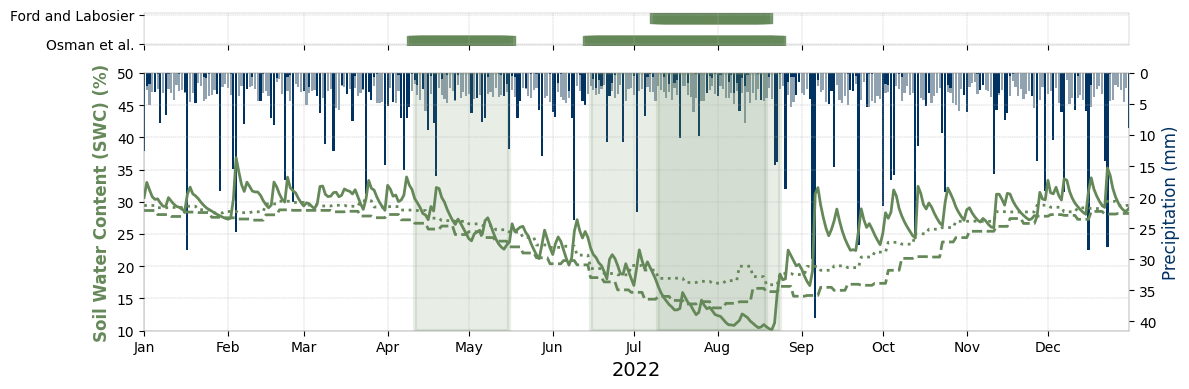

In [ ]:
# Define methods and corresponding colors
methods = ["Alencar et al.", "Noguera et al.", "Osman et al.", 
           "Ford and Labosier", "Pendergrass et al.", "Christian et al."]
colors = ["#48787E", "#B1B455", "#658859", "#658859", "#3D5142", "#3D5142"]

# Define subplot groups
subplot_osman_ford = ["Osman et al.", "Ford and Labosier"]

# Create figure and only ax3 and ax2
fig, (ax3, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, 
                               gridspec_kw={'height_ratios': [0.2, 1.6]})

# ---------------------------
# AX2 - Soil Water Content
# ---------------------------
swc_columns = ['swc_p20', "swc", 'swc_p40']
swc_legend_names = ['swc p20', 'swc', 'swc p40']
swc_styles = ['dashed', '-', 'dotted']
swc_colors = ['#658859', "#658859", '#658859']

for i, column in enumerate(swc_columns):
    ax2.plot(flash_drought_df['Date'], flash_drought_df[column], label=swc_legend_names[i], 
             color=swc_colors[i], linestyle=swc_styles[i], linewidth=2)

ax2.set_ylabel('Soil Water Content (SWC) (%)', fontsize=12, fontweight='bold', color='#658859')
ax2.grid(True, linestyle='--', linewidth=0.3)

# Add precipitation bars on secondary axis
ax2_2 = ax2.twinx()
ax2_2.bar(daily_mean_pr['Full_Date'], daily_mean_pr["precipitation"], 
          color="#91A3B0", linestyle='--', linewidth=1, label="Mean Precipitation")
ax2_2.bar(flash_drought_df['Date'], flash_drought_df['precipitation'], 
          color="#003262", label="Daily Precipitation")

ax2_2.invert_yaxis()
ax2_2.set_ylabel('Precipitation (mm)', fontsize=12, color='#003262')
ax2.set_xlabel('2022', fontsize=14)
ax2.set_ylim(10, 50)

# ---------------------------
# AX3 - Osman & Ford Scatter (tighter spacing)
# ---------------------------
spacing_osman_ford = 1.0
for i, method in enumerate(subplot_osman_ford):
    indices = flash_drought_df['Date'][flash_drought_df[method] == 1]
    color = colors[methods.index(method)]
    ax3.scatter(indices, [i * spacing_osman_ford] * len(indices), c=color, marker='s', s=120, alpha=0.85, label=method)

ax3.set_yticks([i * spacing_osman_ford for i in range(len(subplot_osman_ford))])
ax3.set_yticklabels(subplot_osman_ford)
ax3.grid(True, linestyle='--', linewidth=0.3)

# ---------------------------
# Shaded Events in ax2 only
# ---------------------------
for _, row in flash_drought_events.iterrows():
    method, start, end = row["Method"], row["Start_Date"], row["End_Date"]
    color = colors[methods.index(method)]
    if method in subplot_osman_ford:
        rect = Rectangle(
            (start, ax2.get_ylim()[0]),
            end - start,
            ax2.get_ylim()[1] - ax2.get_ylim()[0],
            linewidth=3,
            edgecolor=color,
            facecolor=color,
            alpha=0.15,
            zorder=1,
        )
        ax2.add_patch(rect)

# ---------------------------
# Aesthetics
# ---------------------------
for ax in [ax2, ax2_2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(0.2)

ax2.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
ax2.set_xticks(pd.date_range(start=start_date, end=end_date, freq='MS'))
ax2.set_xticklabels([date.strftime('%b') for date in pd.date_range(start=start_date, end=end_date, freq='MS')])


ax2.set_zorder(2)
ax2_2.set_zorder(1)
ax2.patch.set_visible(False)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save figure (add your path)
fig.savefig('path/FigureNE.png', format='png', dpi=600, transparent=True)